In [321]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv("university_rank_no_nan.csv", index_col=0)
print(df.isnull().sum())
print(df.head())

Country                      0
Number_students              0
Numb_students_per_Staff      0
Score_Result                 0
Rank                         0
Teaching                     0
Research                     0
Citations                    0
Industry_Income              0
International_Outlook        0
International_Students(%)    0
Percentage_Female(%)         0
Percentage_Male(%)           0
dtype: int64
                                              Country  Number_students  \
University of Oxford                   United Kingdom           20.664   
California Institute of Technology      United States            2.240   
University of Cambridge                United Kingdom           18.978   
Stanford University                     United States           16.135   
Massachusetts Institute of Technology   United States           11.247   

                                       Numb_students_per_Staff  Score_Result  \
University of Oxford                                      1

In [322]:
status = []
for row in df['Rank']:
    if row < 200: status.append('prestigious')
    elif 200 <= row < 300: status.append('reputable')
    elif 300 <= row < 430: status.append('average')
    elif row >= 430: status.append('badReputation')

df['Status'] = status
print(df.head(10))
print(df.isnull().sum())

                                              Country  Number_students  \
University of Oxford                   United Kingdom           20.664   
California Institute of Technology      United States            2.240   
University of Cambridge                United Kingdom           18.978   
Stanford University                     United States           16.135   
Massachusetts Institute of Technology   United States           11.247   
Princeton University                    United States            7.983   
Harvard University                      United States           20.823   
Yale University                         United States           12.402   
University of Chicago                   United States           13.833   
Imperial College London                United Kingdom           16.760   

                                       Numb_students_per_Staff  Score_Result  \
University of Oxford                                      11.2          95.4   
California Institute of T

<AxesSubplot:xlabel='Status', ylabel='count'>

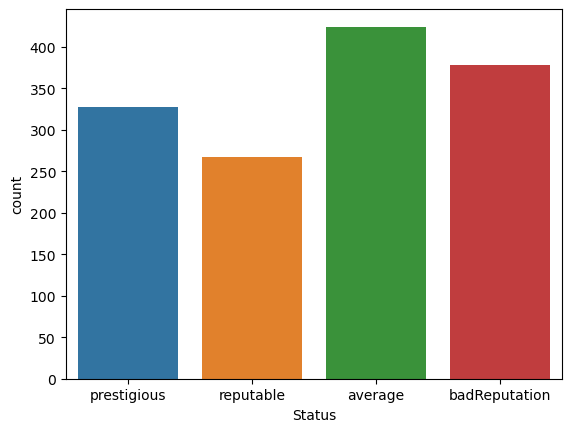

In [323]:
sns.countplot(data=df, x="Status")

In [329]:
print(df.loc[df['Country'] == 'Slovenia']['Status'])

University of Ljubljana    average
University of Maribor      average
Name: Status, dtype: object


In [325]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

print(categorical_columns)
print(numeric_columns)

['Country', 'International_Outlook', 'Status']
['Number_students', 'Numb_students_per_Staff', 'Score_Result', 'Rank', 'Teaching', 'Research', 'Citations', 'Industry_Income', 'International_Students(%)', 'Percentage_Female(%)', 'Percentage_Male(%)']


In [326]:
inputData1 = df.columns.tolist()
outputData1 = inputData1[-1]
inputData1.remove(outputData1)
inputData1.remove("Rank")
inputData1.remove("Score_Result")

df1 = df.copy(deep=True)

le = preprocessing.LabelEncoder()
df1['Country'] = le.fit_transform(df1['Country'])
df1['International_Outlook'] = le.fit_transform(df1['International_Outlook'])
df1[numeric_columns] = StandardScaler().fit_transform(df1[numeric_columns])

k_fold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
cv_results1 = cross_val_score(RandomForestClassifier(n_estimators=60),
                               df1[inputData1],
                               df1[outputData1],
                               cv=k_fold,
                               scoring='accuracy')

print("Accuracy of first classification:", cv_results1.mean())

Accuracy of first classification: 0.9219073220686124


In [327]:
df2 = df.copy(deep=True)

df2 = pd.get_dummies(df2, columns=categorical_columns[:2])
df2[numeric_columns] = StandardScaler().fit_transform(df2[numeric_columns])

inputData2 = df2.columns.tolist()
outputData2 = inputData2[11]
inputData2.remove(outputData2)
inputData2.remove("Rank")
inputData2.remove("Score_Result")

k_fold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
cv_results2 = cross_val_score(RandomForestClassifier(n_estimators=60),
                               df2[inputData2],
                               df2[outputData2],
                               cv=k_fold,
                               scoring='accuracy')

print("Accuracy of second classification:", cv_results2.mean())

Accuracy of second classification: 0.8853891449052739


In [330]:
params = {
    'n_estimators': sp_randint(1, 1500),
    'max_depth': sp_randint(2, 50),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

clf = RandomizedSearchCV(RandomForestClassifier(),
                         param_distributions=params,
                         cv=5,
                         n_iter=50,
                         scoring='accuracy')

clf.fit(df2[inputData2], df2[outputData2])

print('Best params settings:', clf.best_params_)
print('Best result:', clf.best_score_)
print('Best use in code is:', clf.best_estimator_)

/Users/gregorsulcer/.conda/envs/tz5/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/gregorsulcer/.conda/envs/tz5/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/gregorsulcer/.conda/envs/tz5/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sq

Best params settings: {'criterion': 'gini', 'max_depth': 29, 'max_features': 'sqrt', 'n_estimators': 164}
Best result: 0.8153251408090119
Best use in code is: RandomForestClassifier(max_depth=29, n_estimators=164)
